# Detection Analysis

This notebook demonstrates how to analyze data products from the detection pipeline.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

In [3]:
def get_difference_id(science_id, template_id):
    _prefixed_science = {f"science_{k}": v for k, v in science_id.items()}
    _prefixed_template = {f"template_{k}": v for k, v in template_id.items()}
    difference_id = {**_prefixed_science, **_prefixed_template}
    return difference_id

def load_fits(image_path, return_hdr=True, return_data=True, return_wcs=True, hdu_index=0):
    with fits.open(image_path) as hdul:
        hdr = hdul[hdu_index].header if return_hdr or return_wcs else None
        wcs = WCS(hdr) if return_wcs else None
        data = hdul[hdu_index].data if return_data else None
    return hdr, wcs, data

def load_table(table_path):
    table = Table.read(table_path, format='ascii').to_pandas()
    return table

def radec_to_xy(ra, dec, wcs, origin=0):
    # ra and dec are in degree unit
    sky_coord = SkyCoord(ra, dec, frame='icrs', unit='deg')
    pixel_coords = skycoord_to_pixel(coords=sky_coord, wcs=wcs, origin=origin)
    return pixel_coords[0], pixel_coords[1]

def xy_in_image(x, y, width, height, offset=0):
    return (0 + offset <= x) & (x < width - offset) & (0 + offset <= y) & (y < height - offset)

def project_source_radec_to_xy(source, science_wcs, template_wcs, difference_wcs, image_width, image_height):
    source_copy = source.copy()
    source_copy = source_copy[source_copy.obj_type=='transient'].reset_index(drop=True)
    
    x_in_science, y_in_science = radec_to_xy(source_copy.ra, source_copy.dec, science_wcs, origin=1)
    source_copy['x_in_science'] = x_in_science
    source_copy['y_in_science'] = y_in_science
    # in_science = xy_in_image(truth_copy.x_in_science, truth_copy.y_in_science, width=image_width, height=image_height, offset=offset)
    # truth_copy = truth_copy[in_science].copy().reset_index(drop=True)

    x_in_template, y_in_template = radec_to_xy(source_copy.ra, source_copy.dec, template_wcs, origin=1)
    source_copy['x_in_template'] = x_in_template
    source_copy['y_in_template'] = y_in_template
    # in_template = xy_in_image(truth_copy.x_in_template, truth_copy.y_in_template, width=image_width, height=image_height, offset=offset)
    # truth_copy = truth_copy[in_template].copy().reset_index(drop=True)

    x_in_difference, y_in_difference = radec_to_xy(source_copy.ra, source_copy.dec, difference_wcs, origin=1)
    source_copy['x_in_difference'] = x_in_difference
    source_copy['y_in_difference'] = y_in_difference
    # in_difference = xy_in_image(truth_copy.x_in_difference, truth_copy.y_in_difference, width=image_width, height=image_height, offset=offset)
    # truth_copy = truth_copy[in_difference].copy().reset_index(drop=True)
    
    return source_copy

def show_image(ax, image, title=None, xlabel=None, ylabel=None, axis_off=False, zscale=True):
    if zscale:
        image = interval(image)
    ax.imshow(image, origin='lower', cmap='gray')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if axis_off:
        ax.set_axis_off()

def add_circles(ax, x, y, radius=0.5, color='red', alpha=1):
    for xp, yp in zip(x, y):
        circle = Circle((xp, yp), radius=radius, color=color, alpha=alpha, fill=False)
        ax.add_patch(circle)

def crop_image(image, cr, cc, half_r = 50, half_c=50, fill_edge=True, fill_value=np.nan):
    
    cr, cc = int(cr), int(cc)
    if  cr <= 0 or image.shape[0] - 1 <= cr or cc <= 0 or image.shape[1] - 1 <= cc:
        raise ValueError(f"Image center at (cr={cr}, cc={cc}) is out of bounds. "
                             f"Valid cr range: [{0}, {image.shape[0]}], y range: [{0}, {image.shape[1]}].")

    half_r, half_c = int(half_r), int(half_c)
    r_left = min(half_r, cr)
    r_right = min(half_r, image.shape[0] - 1 - cr)
    c_left = min(half_c, cc)
    c_right = min(half_c, image.shape[1] - 1 - cc)

    image_slice = image[cr - r_left: cr + r_right + 1, cc - c_left: cc + c_right + 1].copy()

    if fill_edge:
        cutout = np.full( (2 * half_r + 1, 2 * half_c + 1), fill_value)
        cutout[half_r - r_left: half_r + r_right + 1, half_c - c_left: half_c + c_right + 1] = image_slice
        return cutout
    else:
        return image_slice

def analyze_detection(row, verbose=True):
    INPUT_IMAGE_PATTERN = ("/global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data"
                                    "/RomanTDS/images/simple_model/{band}/{pointing}/Roman_TDS_simple_model_{band}_{pointing}_{sca}.fits.gz")
    INPUT_TRUTH_PATTERN = ("/global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data"
                                 "/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{sca}.txt")
    
    DIFF_IMAGE_PREFIX = 'decorr_diff_'
    DIFF_DETECTION_PREFIX = 'detection_'
    DIFF_TRUTH_PREFIX = 'truth_'
    TRANSIENTS_TO_DETECTION_PREFIX = 'transients_to_detection_'
    DETECTION_TO_TRANSIENTS_PREFIX = 'detection_to_transients_'
    DIFF_PATTERN = '{science_band}_{science_pointing}_{science_sca}_-_{template_band}_{template_pointing}_{template_sca}'
    
    OUTPUT_DIR = "../../test_output"
    
    IMAGE_WIDTH = 4088
    IMAGE_HEIGHT = 4088

    science_id = {'band': row['science_band'], 'pointing': row['science_pointing'], 'sca': row['science_sca']}
    template_id = {'band': row['template_band'], 'pointing': row['template_pointing'], 'sca': row['template_sca']}
    difference_id = get_difference_id(science_id, template_id)
    diff_pattern = DIFF_PATTERN.format(**difference_id)
    
    science_image_path = INPUT_IMAGE_PATTERN.format(**science_id)
    science_truth_path = INPUT_TRUTH_PATTERN.format(**science_id)
    
    template_image_path = INPUT_IMAGE_PATTERN.format(**template_id)
    template_truth_path = INPUT_TRUTH_PATTERN.format(**template_id)
    
    difference_image_path = os.path.join(OUTPUT_DIR, diff_pattern, DIFF_IMAGE_PREFIX + diff_pattern + '.fits')
    transients_to_detection_path = os.path.join(OUTPUT_DIR, diff_pattern, TRANSIENTS_TO_DETECTION_PREFIX + diff_pattern + '.csv')
    detection_to_transients_path = os.path.join(OUTPUT_DIR, diff_pattern, DETECTION_TO_TRANSIENTS_PREFIX + diff_pattern + '.csv')
    
    _, science_wcs, science_image = load_fits(science_image_path, hdu_index=1)
    _, template_wcs, template_image = load_fits(template_image_path, hdu_index=1)
    _, difference_wcs, difference_image = load_fits(difference_image_path, hdu_index=0)
    
    transients_to_detection = pd.read_csv(transients_to_detection_path)
    transients_to_detection = project_source_radec_to_xy(transients_to_detection, science_wcs, template_wcs, difference_wcs, IMAGE_WIDTH, IMAGE_HEIGHT)
    detection_to_transients = pd.read_csv(detection_to_transients_path)

    data_products = {}
    data_products['science_image'] = science_image
    data_products['template_image'] = template_image
    data_products['difference_image'] = difference_image

    data_products['transients_to_detection'] = transients_to_detection
    data_products['detection_to_transients'] = detection_to_transients
    
    return data_products

def visualize_sources_on_image(dp):
    matched_transients = dp['transients_to_detection'][dp['transients_to_detection'].matched_status].copy().reset_index(drop=True)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    show_image(ax[0], dp['science_image'], title='Science', axis_off=True)
    add_circles(ax[0], dp['transients_to_detection'].x_in_science - 1, dp['transients_to_detection'].y_in_science - 1, radius=15, color='red')
    add_circles(ax[0], matched_transients.x_in_science - 1, matched_transients.y_in_science - 1, radius=25, color='blue')
    
    show_image(ax[1], dp['template_image'], title='Template', axis_off=True)
    add_circles(ax[1], dp['transients_to_detection'].x_in_template - 1, dp['transients_to_detection'].y_in_template - 1, radius=15, color='red')
    add_circles(ax[1], matched_transients.x_in_template - 1, matched_transients.y_in_template - 1, radius=25, color='blue')
    
    show_image(ax[2], dp['difference_image'], title='Difference')
    add_circles(ax[2], dp['transients_to_detection'].x_in_difference - 1, dp['transients_to_detection'].y_in_difference - 1, radius=15, color='red')
    add_circles(ax[2], matched_transients.x_in_difference - 1, matched_transients.y_in_difference - 1, radius=25, color='blue')
    
    red_patch = mpatches.Patch(color='red', label='Science Truth')
    blue_patch = mpatches.Patch(color='blue', label='Detected Truth')
    fig.legend(handles=[red_patch, blue_patch], loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.2))
    
    fig.subplots_adjust(bottom=0)

def visualize_stamps(dp, figsize=(10, 55)):

    fig, axes = plt.subplots(len(dp['transients_to_detection']), 3, figsize=(10, 55))
    
    for i, row in dp['transients_to_detection'].iterrows():
        science_cutout = crop_image(dp['science_image'],
                                    cr=row['y_in_science'] - 1,
                                    cc=row['x_in_science'] - 1,
                                    half_r = 50, half_c=50,
                                    fill_edge=True, fill_value=np.nan)

        template_cutout = crop_image(dp['template_image'],
                                     cr=row['y_in_template'] - 1,
                                     cc=row['x_in_template'] - 1,
                                     half_r = 50, half_c=50,
                                     fill_edge=True, fill_value=np.nan)

        difference_cutout = crop_image(dp['difference_image'],
                                       cr=row['y_in_difference'] - 1,
                                       cc=row['x_in_difference'] - 1,
                                       half_r = 50, half_c=50,
                                       fill_edge=True, fill_value=np.nan)
    
        axes[i][0].imshow(interval(science_cutout), cmap='gray', origin='lower')
        axes[i][0].set_title(f"Flux: {row['realized_flux']:.3f}")
        
        axes[i][1].imshow(interval(template_cutout), cmap='gray', origin='lower')
        
        axes[i][2].imshow(interval(difference_cutout), cmap='gray', origin='lower')
        axes[i][2].set_title(f"Detected: {row['matched_status']}")
        
        for j in range(3):
            add_circles(axes[i][j], [50], [50], radius=5, color='red')
            axes[i][j].set_axis_off()

In [5]:
data_records = pd.read_csv('../test/test_ten_data_records.csv')

In [6]:
row = data_records.iloc[0]
dp = analyze_detection(row)
print(f"Efficiency: {dp['transients_to_detection'].matched_status.sum() / len(dp['transients_to_detection']): .3f},"
      f"Purity: {dp['detection_to_transients'].matched_status.sum() / len(dp['detection_to_transients']): .3f}")

Efficiency:  0.033,Purity:  0.001


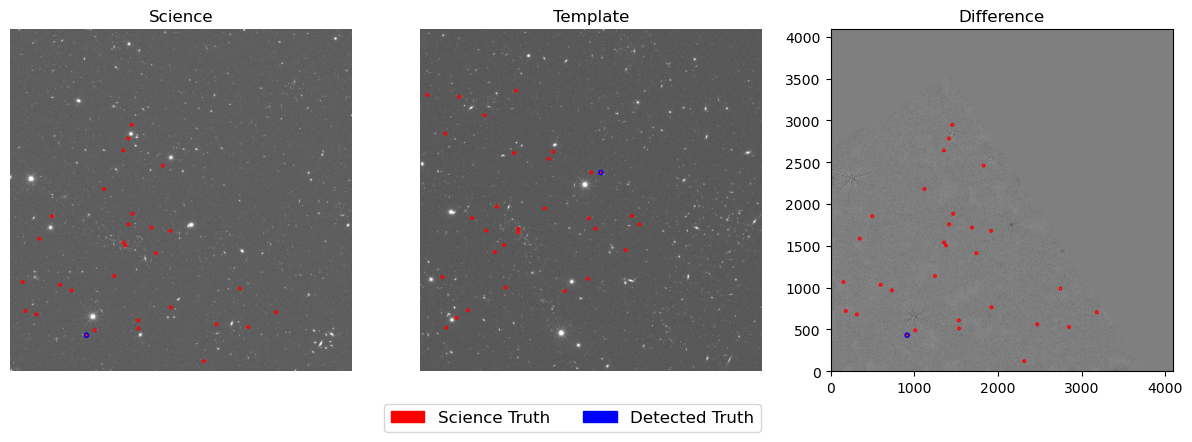

In [7]:
visualize_sources_on_image(dp)

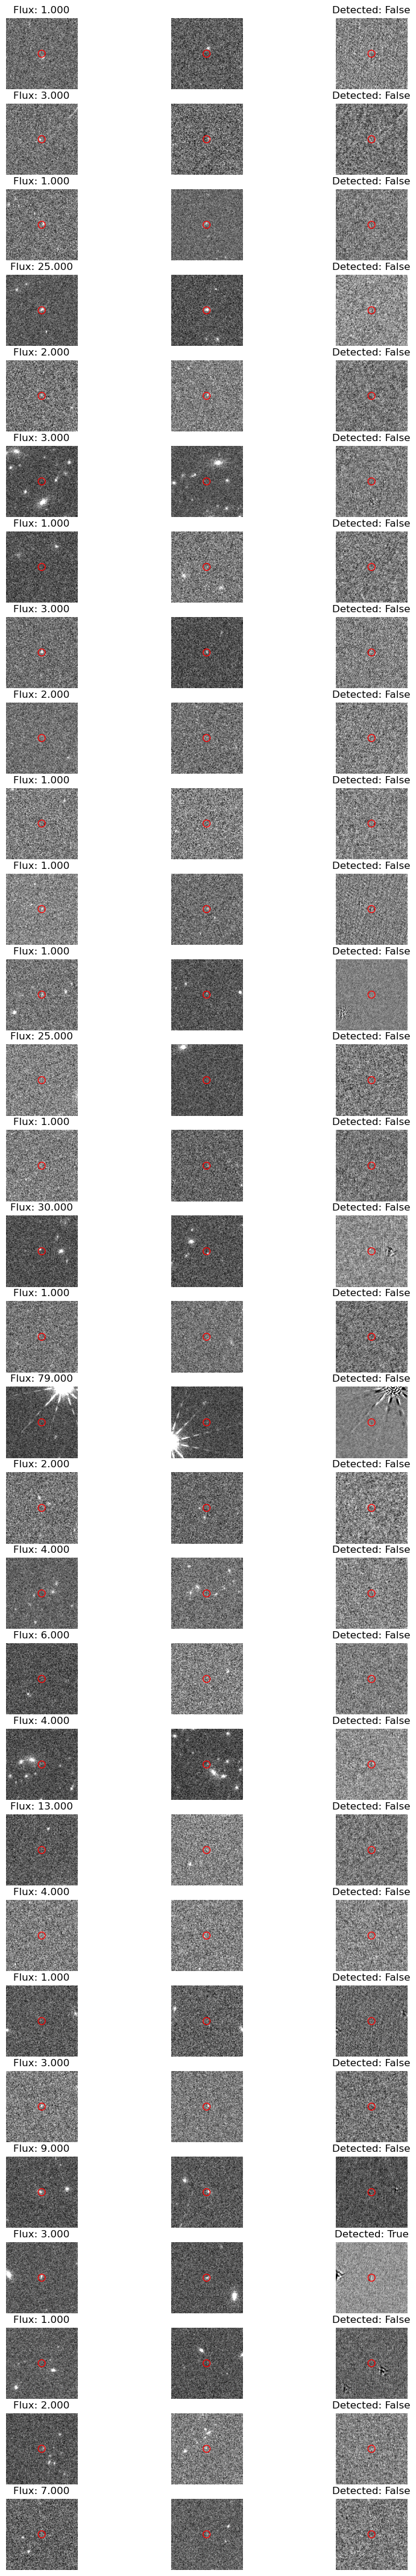

In [8]:
visualize_stamps(dp, figsize=(10, 55))